In [1]:
import serial
import time
import random
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tqdm
from tqdm import tqdm

In [2]:
RANDOM_SEED = 1
random.seed(RANDOM_SEED)

### General Helper Functions

In [3]:
def load_and_prep_data(data_path):
    raw_df = pd.read_csv(data_path)
    data_df = raw_df.copy()
    # Make current positive
    data_df = data_df.drop_duplicates(subset=['motor_1_position','motor_2_position'])
    data_df['I_ivp_1'] = data_df['I_ivp_1'].abs()
    data_df['power'] = data_df['I_ivp_1'] * data_df['V_ivp_1']
    return data_df

In [4]:
def convert_motor_positions_to_index(position_tuple):
    # position tuple is (m1 position, m2 position)
    return (int(position_tuple[0]//5), int(position_tuple[1]//5))

def convert_index_to_motor_positions(index_tuple):
    return (index_tuple[0]*5, index_tuple[1]*5)

In [5]:
def arg_max_array_index_loop(array):
    # Finds the argmax and randomly selects if multiple
    array_max = -10000
    max_list = []
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if array[i][j] > array_max:
                array_max = array[i][j]
                max_list = [[i,j]]
            elif array[i][j] == array_max:
                max_list.append([i,j])
    if len(max_list) > 1:
        random.seed(RANDOM_SEED)
        max_index = random.choice(max_list)
    else:
        max_index = max_list[0]
    return max_index

In [6]:
def arg_max_array_index(array):
    max_indeces = np.where(array == array.max())
    index_pairs = [(max_indeces[0][x], max_indeces[1][x]) for x in range(len(max_indeces[0]))]
#     random.seed(RANDOM_SEED)
    return random.choice(index_pairs)

def random_array_index(array):
    x_index = range(array.shape[0])
    y_index = range(array.shape[1])
#     random.seed(RANDOM_SEED)
    return (random.choice(x_index), random.choice(y_index))

### Environment Class

In [7]:
class SolarEnv:
    def __init__(self, reward_data_path, shape=(37,37), control=None):
        self.shape = shape
        self.reward_array = np.zeros(shape)
        # load in reward data
        rewards = load_and_prep_data(reward_data_path)
        for index, row in rewards.iterrows():
            motor_1_index = int(row['motor_1_position'].item()//5)
            motor_2_index = int(row['motor_2_position'].item()//5)
            position_reward = row['power'].item()
            self.reward_array[motor_1_index][motor_2_index] = position_reward
        if control is not None:
            self.reward_array = np.full(shape, control)
    
    # For debugging
    def get_reward_array(self):
        return self.reward_array
    
    def get_env_shape(self):
        return self.reward_array.shape
                                          
    # Not needed right now
    def env_init(self):
        """
        Setup for the environment called when the experiment first starts.
        """
        pass
    
    # Not needed right now
    def env_start(self):
        """
        The first method called when the experiment starts, called before the
        agent starts.

        Returns:
            The first state from the environment.
        """
        pass
    
    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent, a tuple of motor positions

        Returns:
            (float, state): a tuple of the reward, state
        """
        index_tuples = convert_motor_positions_to_index(action)
        return self.reward_array[index_tuples[0]][index_tuples[1]], convert_index_to_motor_positions(index_tuples)

Visualizing the reward array

### Agent Class

Agent will start out as a TD(0) agent with epsilon-greedy policy
* V(st) = V(st) + step_size * [Rewardt+1 + discount_factor * V(st+1) - V(st)]

**Improvements**
The new agent will use TD(0) but has some slight changes to account for the visitation bias in the last experiment.

v(st) <- v(st) + step_size * [reward - v(st)] * [1 + tanh(abs((reward - v(st))/v(st)))]^chi

Here chi is a tuneable parameter but will start as a factor of 2

---
#### Quick experiment

In [8]:
last_value = 4.32
chi = 2
reward = 7

In [9]:
print(last_value + 0.1*(reward - last_value) * (1 + np.tanh(np.abs((reward - last_value)/last_value)))**chi)

4.965021878225688


In [10]:
def simulate_thing_tanh(initial_value, chi, reward, steps):
    last_value = initial_value
    for i in range(steps):
        update = last_value + 0.1*(reward - last_value) * (1 + np.tanh(np.abs((reward - last_value)/last_value)))**chi
        last_value = update
        print(round(update,4))
        
def simulate_thing_no_scaling(initial_value, chi, reward, steps):
    last_value = initial_value
    for i in range(steps):
        update = last_value + 0.1*(reward - last_value)
        last_value = update
        print(round(update,4))
        
def simulate_thing_notanh(initial_value, chi, reward, steps):
    last_value = initial_value
    for i in range(steps):
        update = last_value + 0.1*(reward - last_value) * (1 + np.abs((reward - last_value)/last_value))**chi
        last_value = update
        print(round(update,4))

In [ ]:
simulate_thing_no_scaling(0.0001, 2, 0.07, 3)

---

#### Agent functions / class

In [11]:
def rolling_avg_calc(value, last_value, window):
    return (1/window)*value + (1-(1/window))*last_value

In [12]:
class SolarAgent:
    def __init__(self, step_size, epsilon, chi, initialization_value, env, rolling_window):
        self.step_size = step_size
        self.epsilon = epsilon
        self.chi = chi
        self.env_shape = env.get_env_shape()
        self.state_values = np.full(self.env_shape, initialization_value)
        self.state_visits = np.zeros(self.env_shape)
        self.last_state = None
        self.state = None
        self.last_reward = None
        self.reward = None
        self.env = env
        self.total_energy = 0
        self.rolling_power = 0
        self.rolling_window = rolling_window
        self.transition_dict = None
        random.seed(RANDOM_SEED)
    
    def get_state_value_array(self):
        return self.state_values.copy()
    
    def agent_policy(self):
        # if random greedy
#         random.seed(RANDOM_SEED)
        if random.random() <= self.epsilon:
            action = random_array_index(self.state_values)
        # otherwise arg max
        else:
            action = arg_max_array_index(self.state_values)
        return convert_index_to_motor_positions(action)
    
    def agent_start(self):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            self.last_action [int] : The first action the agent takes.
        """
        self.last_state = [90,90]
        self.last_reward = 0
        self.state, self.reward = self.env.env_step(self.last_state)
    
    def get_state_values(self, state):
        converted_index = convert_motor_positions_to_index(state)
        return self.state_values[converted_index[0]][converted_index[1]]
    
    def agent_step(self):
        """A step taken by the agent.
        Args:
            reward [float]: the reward received for taking the last action taken
            state [int]: the state from the environment's step, where the agent ended up after the last step
        Returns:
            self.last_action [int] : The action the agent is taking.
        """
        # Make a policy decision
        action = self.agent_policy()
        
        # Interact with the environment
        reward, next_state = self.env.env_step(action)
        
        # TD Update
        last_state_value = self.get_state_values(self.last_state)
        new_state_value = self.get_state_values(next_state)
        error_term = reward - last_state_value
        scaling_term = (1 + np.tanh(np.abs(error_term/last_state_value)))**self.chi
        last_state_index = convert_motor_positions_to_index(self.last_state)
        self.state_values[last_state_index[0]][last_state_index[1]] = last_state_value + self.step_size * error_term * scaling_term
        
        # For debugging
        self.transition_dict = {
            'reward': reward,
            'new_state_value': new_state_value,
            'last_state_value': last_state_value,
            'error_term': error_term,
            'updated_value_estimate': last_state_value + self.step_size * error_term
        }
        
        # Update internal variables
        self.last_state = next_state
        
        # For tracking
        self.total_energy += reward
        self.rolling_power = rolling_avg_calc(reward, self.rolling_power, self.rolling_window)
        self.state_visits[last_state_index[0]][last_state_index[1]] += 1
    
    def get_agent_energy(self):
        return self.total_energy
    
    def get_agent_rolling_power(self):
        return self.rolling_power
    
    def get_transition_dict(self):
        return self.transition_dict
    
    def get_state_visits(self):
        return self.state_visits.copy()
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        pass

### Experiment Functions

In [13]:
def calculate_value_error(agent_array, env_array):
    return np.sqrt((agent_array - env_array)**2).mean()

In [14]:
def progress_dict_to_df(progress_dict):
    dict_list = []
    for x in progress_dict.keys():
        temp_dict = progress_dict[x]
        temp_dict['step'] = x
        dict_list.append(temp_dict)
    return pd.DataFrame(dict_list)

In [58]:
def run_agent_experiment(exp_agent, exp_env, steps, interval):
    progress_dict = {}
    exp_agent.agent_start()
    progress_dict['0'] = {
                'state_value': exp_agent.get_state_value_array(),
                'rolling_power': exp_agent.get_agent_rolling_power(),
                'mse': calculate_value_error(exp_agent.get_state_value_array(), exp_env.get_reward_array()),
                'state_visits': exp_agent.get_state_visits(),
                'total_energy': exp_agent.get_agent_energy()
            }
    for i in tqdm(range(1, steps + 1)):
        exp_agent.agent_step()
        if i%interval == 0:
            progress_dict[str(i)] = {
                'state_value': exp_agent.get_state_value_array(),
                'rolling_power': exp_agent.get_agent_rolling_power(),
                'mse': calculate_value_error(exp_agent.get_state_value_array(), exp_env.get_reward_array()),
                'state_visits': exp_agent.get_state_visits(),
                'total_energy': exp_agent.get_agent_energy()
            }
    progress_df = progress_dict_to_df(progress_dict)
    return exp_agent, progress_dict, progress_df

In [87]:
def plot_rolling_power(progress_df, exp_env, height, width):
    max_output = exp_env.get_reward_array().max()
    progress_df['env_max'] = max_output
    progress_df['optimal_energy'] = progress_df['step'].astype(float) * max_output
    progress_df['difference'] = (progress_df['rolling_power'] - progress_df['env_max']) / progress_df['env_max']
    make_subplots_plot(df=progress_df, x='step', subplot_group_list=[
    {
        'title': 'Reward Comparison (Agent vs Max)',
         'columns': ['env_max','rolling_power']
    },
        {
        'title': 'Energy Comparison (Agent vs Max)',
         'columns': ['total_energy', 'optimal_energy']
        }
    ], height=height, width=width
                 )
            

In [88]:
def make_subplots_plot(df, x, subplot_group_list, height=400, width=400, plot_title=''):
    fig = make_subplots(rows=len(subplot_group_list), cols=1,
                       subplot_titles=[x['title'] for x in subplot_group_list])
    
    for i in range(len(subplot_group_list)):
        row = i+1
        title = subplot_group_list[i]['title']
        for column_name in subplot_group_list[i]['columns']:
            fig.append_trace(go.Scatter(
                x=df[x],
                y=df[column_name], name=column_name
            ), row=row, col=1)

    fig.update_layout(height=height, width=width, title_text=plot_title)
    fig.show()

In [89]:
def plot_array_evolution(exp_progress_dict, exp_interval, field, width_plot, height_plot, zmax=None, zmin=None):
    matrix_list = [exp_progress_dict[x][field] for x in exp_progress_dict.keys()]
    fig = go.Figure(
        data=[go.Heatmap(z=matrix_list[0], zmax=zmax, zmin=zmin)],layout=go.Layout(
                title="Step 0",
                updatemenus=[dict(
                    type="buttons",
                    buttons=[dict(label="Play",
                                  method="animate",
                                  args=[None]),
                            dict(label="Pause",
                                 method="animate",
                                 args=[None,
                                       {"frame": {"duration": 0, "redraw": False},
                                        "mode": "immediate",
                                        "transition": {"duration": 0}}],
                                 )])]
            ),
            frames=[go.Frame(data=[go.Heatmap(z=matrix_list[i])], 
                             layout=go.Layout(title_text=f"Step {i * exp_interval}")) for i in range(1, len(matrix_list))]
    )
    fig.update_yaxes(autorange="reversed")
    fig.update_layout({
        'height': height_plot,
        'width': width_plot}
    )

    fig.show()

### Resume here with experiment

In [114]:
# Set plotting max/min
zmax_plot = 0.015
zmin_plot = 0
width_plot = 400
height_plot = 400

In [115]:
# Environment factors
exp_env_control = None
exp_data_path = '../../../rl_agent/simulation_data/data/corrected_motors/run_5_kitchen_no_lights.csv'

In [159]:
# Set runtime values
steps = 100000
interval = 1000

# Agent factors
exp_step_size = 0.1
exp_epsilon = 0.06
exp_chi = 1.2
exp_initialization_value = 0.0001
rolling_avg_steps = 10

In [160]:
experiment_env = SolarEnv(reward_data_path=exp_data_path, shape=(37,37), control=exp_env_control)
experiment_agent = SolarAgent(step_size=exp_step_size, epsilon=exp_epsilon, 
                              chi=exp_chi, initialization_value=exp_initialization_value, 
                              env=experiment_env, rolling_window=rolling_avg_steps)

#### Initiate an experiment
Remember to re-initialize the agent above or else it will resume learning on the exisitng agent

In [161]:
experiment_agent, progress_dict, progress_df = run_agent_experiment(exp_agent=experiment_agent, 
                                                                   exp_env=experiment_env, steps=steps, interval=interval)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 32267.69it/s]


#### Show the agent difference from known optimal policy

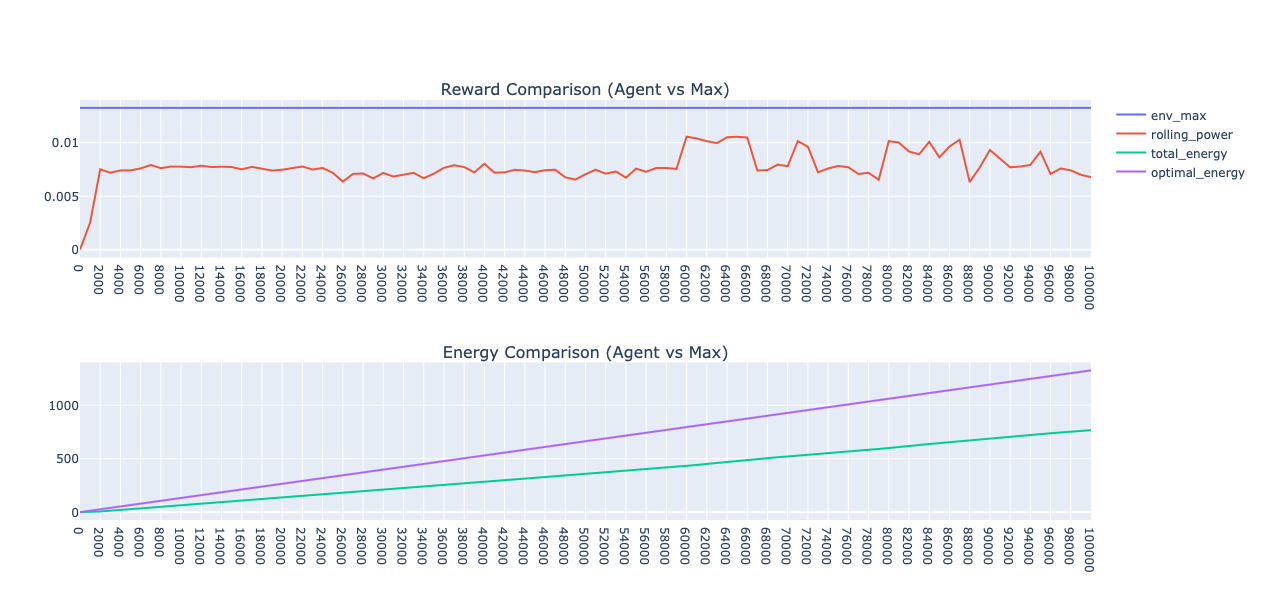

In [162]:
plot_rolling_power(progress_df, experiment_env, height=600, width=600)

#### Visualize state visits and learned values

In [144]:
do_max_step = True
specific_step = '100000'

State visits

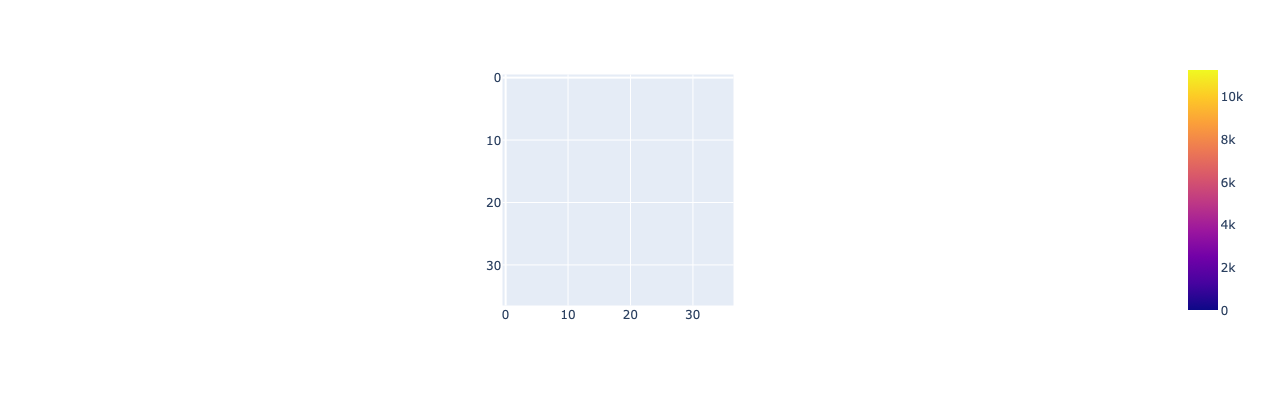

In [145]:
px.imshow(progress_dict[(specific_step if not do_max_step else str(steps))]['state_visits'], width=width_plot, height=height_plot)

State values

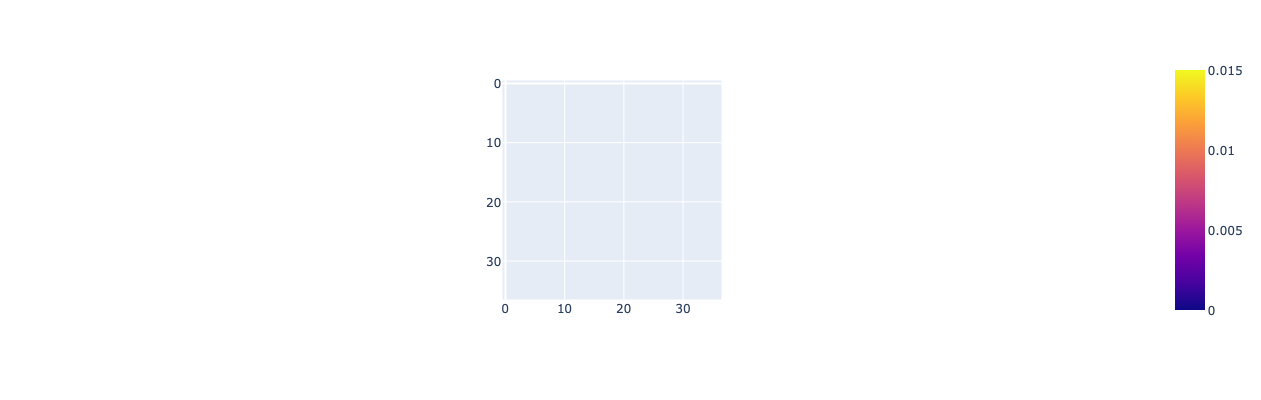

In [146]:
px.imshow(progress_dict[(specific_step if not do_max_step else str(steps))]['state_value'], width=width_plot, 
          height=height_plot, zmin=zmin_plot, zmax=zmax_plot)

#### Environment True Value

In [ ]:
px.imshow(experiment_env.get_reward_array(), width=width_plot, height=height_plot)

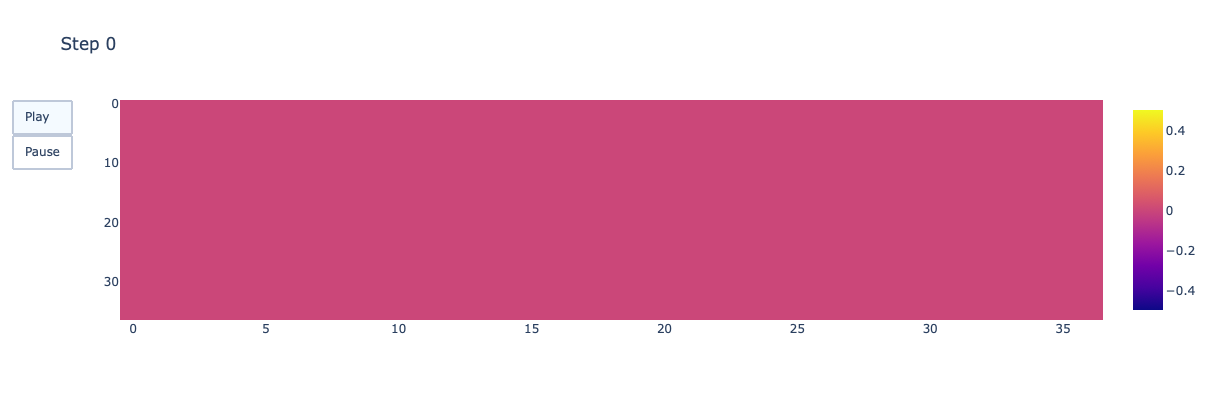

In [ ]:
plot_array_evolution(progress_dict, interval, 'state_visits', width_plot, height_plot)

#### Visulaize evolution of learned state value

In [ ]:
plot_array_evolution(progress_dict, interval, 'state_value', width_plot, height_plot, zmax_plot, zmin_plot)

In [ ]:
# MSE vs steps
px.scatter(progress_df, x='step', y='rolling_power', width=width_plot, height=height_plot)

----
----

In [ ]:
# Request codes
MOTOR_CONTROL = 1000
STATE_REQUEST = 2000
RESET_CODE = 6666

def scan_space(arduino):
    # Run start
    run_start = time.time()
    data_dict_list = []
    last_motor_interval = 0
    last_measure_interval = -1
    motor_frequency = 2
    measure_frequency = 1
    # Set timeouts
    abort = False
    
    for xy_degree in range(0, 181, 5):
        for yz_degree in range(0, 181, 5):
            si.write_serial_line(arduino, [MOTOR_CONTROL, xy_degree, yz_degree], print_message=False)
            new_message, abort = si.listen_for_serial(arduino)
            if new_message is not None and not abort:
                data_dict_list.append(new_message)
            elif abort:
                break
            else:
                print('Empty message received without abort issue')
            time.sleep(0.1) # Wait for steady state
        if abort:
            break
        print('xy:',xy_degree,'yz:',yz_degree)
    # Write back to start state
    write_serial_line(arduino, [si.MOTOR_CONTROL, 90, 90])

    return pd.DataFrame(data_dict_list)

In [ ]:
if __name__ == '__main__':
    print('\nARDUINO CONTROL TESTING')
    print('-------------------------')
    # Initialize serial port
    print('\nIniitalizing device...')
    serial_port = '/dev/cu.usbmodem14101'
    baud_rate = 9600
    timeout = 5
    arduino = si.initialize_serial(serial_port=serial_port, baud_rate=baud_rate, timeout=timeout)
    print('\t - SUCCESS: Device initialized.')
    
    si.write_serial_line(arduino, [MOTOR_CONTROL, 90, 90])

    # Run a loop where motor position incremented every 5 seconds, print out message
    print('\nBeginning loop sequence...')
#     data = scan_space(arduino)
    print('\t - Loop complete.')

    # Add relative time to returned data and print out
#     data['t_relative'] = data['timestamp'] - data['timestamp'].iloc[0]
    print('\nData broadcasted by Arduino:\n')
    
#     data.to_csv('/Users/jackogrady/Git/rl-solar/rl_agent/simulation_data/data/run_6_kitchen_no_lights_swapped_motors.csv', index=False)

In [ ]:
print(data)

In [ ]:
write_serial_line(arduino, [1000, 180, 90])